In [2]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm








#beta_rel = 0.305
beta_rel = 0.106

#gamma = 1.050
gamma = 1.006


I=0.4
L = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
B = 0.060 # T for LEIR
B_ratio=1e-10
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



length = 182.43280000000 #m
T = length/(c*beta_rel)
ms_per_turn = 1000*T





beta_x=10 
beta_y=4
emittance=10*1e-6





num_particles=int(1e5)



/home/pkruyt/cernbox/xsuite/xtrack/ducktrack/elements.py:892: RuntimeWarning: invalid value encountered in true_divide
  p.theta = np.arctan(p.y/p.x)


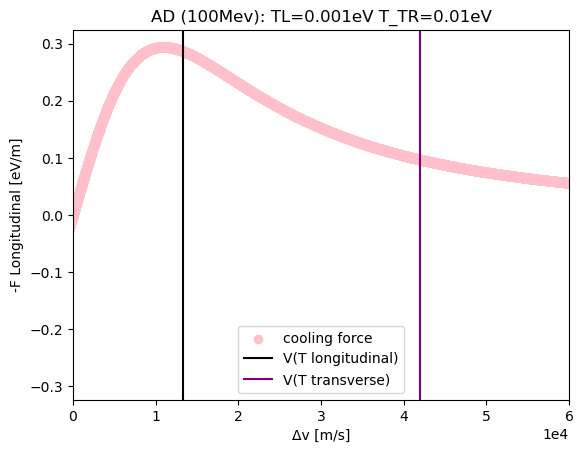

In [3]:
#force againt velocity


dtk_particle = dtk.TestParticles(
    
    mass0=mass0,
    p0c=p0c,
    x=np.random.normal(0,0 ,num_particles),
    px=np.random.normal(0, 4*np.sqrt(emittance/beta_x), num_particles),
    y=0,
    py=0,
    delta=0,
    zeta=0)



dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                                T_perp=T_perp,T_l=T_l,
                                                B=B,Z=Z,B_ratio=1e-10,
                                                Neutralisation_space_charge=0,Neutralisation_rotation=0)


force = dtk_cooler.force(dtk_particle)

def temperature_to_velocity_1D(temperature_eV):
    
    T=temperature_eV#J
    mass = 511 *1e3
    velocity = c*np.sqrt( T/ mass)
    return velocity


px_tot = p0c*dtk_particle.px
beta_diff = px_tot/(mass0*gamma)
v_diff = beta_diff*c


plt.figure()
plt.scatter(v_diff,-force,color='pink',label='cooling force')
plt.axvline(temperature_to_velocity_1D(T_l),color='black',label='V(T longitudinal)')
plt.axvline(temperature_to_velocity_1D(T_perp),color='purple',label='V(T transverse)')
plt.xlim([0,0.6*1e5])

plt.title(f'AD (100Mev): TL={T_l}eV T_TR={T_perp}eV')
plt.legend()
plt.ylabel('-F Longitudinal [eV/m]')
plt.xlabel('Δv [m/s]')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()


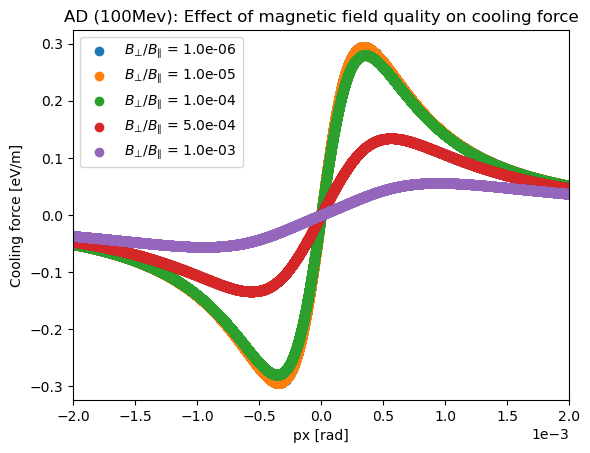

In [4]:
#Magnetic field quality

B_ratios = [1e-6,1e-5,1e-4,5e-4,1e-3]
#B_ratios = [1e-4,5e-4,1e-3]


dtk_particle = dtk.TestParticles(
    
    mass0=mass0,
    p0c=p0c,
    x=np.random.normal(0,0 ,num_particles),
    px=np.random.normal(0, 4*np.sqrt(emittance/beta_x), num_particles),
    y=0,
    py=0,
    delta=0,
    zeta=0)


for B_ratio_loop in B_ratios:

    dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                                T_perp=T_perp,T_l=T_l,
                                                B=B,Z=Z,B_ratio=B_ratio_loop,
                                                Neutralisation_space_charge=0,Neutralisation_rotation=0)


    force = dtk_cooler.force(dtk_particle)

    plt.scatter(dtk_particle.px,-force, label=f"$B_{'⊥'}$/$B_{'∥'}$ = {B_ratio_loop:.1e}")

    plt.xlabel("px [rad]")
    plt.ylabel("Cooling force [eV/m]")
    plt.title('AD (100Mev): Effect of magnetic field quality on cooling force')
    plt.xlim([-0.0020,0.0020])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.legend()

100%|██████████| 1/1 [00:17<00:00, 17.07s/it]


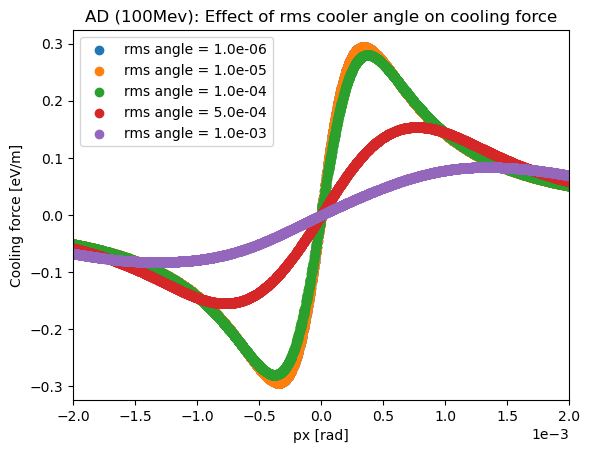

In [5]:
#Angle instead of magnetic field quality?

angle_loop = [1e-6,1e-5,1e-4,5e-4,1e-3]
#angle_loop = [1e-4,5e-4,1e-3]

#B_ratios = [1e-6,1e-3]

num_particles=int(1e4)

dtk_particle = dtk.TestParticles(
    
    mass0=mass0,
    p0c=p0c,
    x=np.random.normal(0,0 ,num_particles),
    px=np.random.normal(0, 4*np.sqrt(emittance/beta_x), num_particles),
    y=0,
    py=0,
    delta=0,
    zeta=0)




plt.figure()
for rms_angle in angle_loop:


    coolers = []
    num_coolers=int(1e4)



    for i in range(num_coolers):
        angle=np.random.normal(0,rms_angle,1)
        #angle=np.random.uniform(-B_ratio,B_ratio,1)
        #print('angle:',angle)
        cooler = dtk.elements.ElectronCooler(I=I, L=L, r_beam=r_beam,
                                            T_perp=T_perp, T_l=T_l,
                                            B=B, Z=Z, B_ratio=0,
                                            Neutralisation_space_charge=0,
                                            xp_cooler=angle)
        coolers.append(cooler)




    num_turns=int(1)


    x=[]
    px=[]
    action = []
    force = []
    force_old = []


    for i in tqdm(range(num_turns)):
        x.append(dtk_particle.x)
        px.append(dtk_particle.px)
        
        action_temp = 0.5*(dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2) #Joule sec
        action.append(action_temp)
        
        #arc.track(dtk_particle)
        force_temp=[]        

        #force_old.append(dtk_cooler.force(dtk_particle))

        for cooler in coolers:
            f1=cooler.force(dtk_particle)
            force_temp.append(f1)
            
            # dtk_cooler.track(dtk_particle)
        force_temp=np.array(force_temp)
        force=force_temp.mean(axis=0)  
        #force=np.squeeze(force)


    x = np.array(x)
    px = np.array(px)
    action = np.array(action)
    force = np.array(force)
    #force_old = np.array(force_old)


    plt.scatter(px,-force,label=f'rms angle = {rms_angle:.1e}')#,vmin=-0.05, vmax=0.05
    #plt.scatter(px,force_old,label='ratio')#,vmin=-0.05, vmax=0.05
    plt.xlabel("px [rad]")
    plt.ylabel("Cooling force [eV/m]")
    plt.title('AD (100Mev): Effect of rms cooler angle on cooling force')
    plt.xlim([-0.0020,0.0020])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.legend()
plt.show()

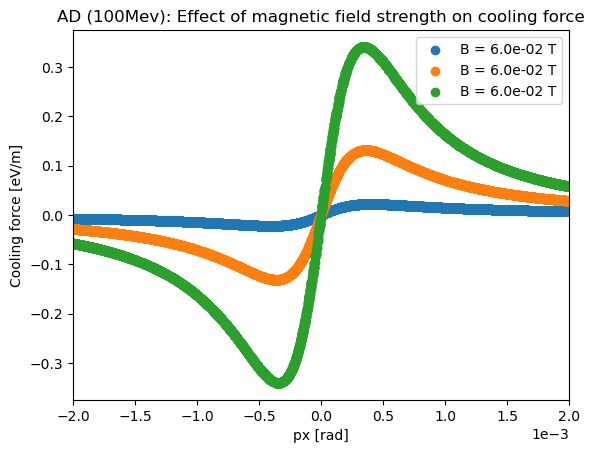

In [6]:
#Magnetic field strength

B_values = [1e-3,1e-2,1e-1]


dtk_particle = dtk.TestParticles(
    
    mass0=mass0,
    p0c=p0c,
    x=np.random.normal(0,0 ,num_particles),
    px=np.random.normal(0, 4*np.sqrt(emittance/beta_x), num_particles),
    y=0,
    py=0,
    delta=0,
    zeta=0)


for B_loop in B_values:

    dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                                T_perp=T_perp,T_l=T_l,
                                                B=B_loop,Z=Z,B_ratio=1e-10,
                                                Neutralisation_space_charge=0,Neutralisation_rotation=0)


    force = dtk_cooler.force(dtk_particle)

    plt.scatter(dtk_particle.px,-force, label=f"B = {B:.1e} T")

    plt.xlabel("px [rad]")
    plt.ylabel("Cooling force [eV/m]")
    plt.title('AD (100Mev): Effect of magnetic field strength on cooling force')
    plt.xlim([-0.0020,0.0020])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.legend()